# Time Series Study - 'Cowboy Cigarettes' Data
by [Sonjoy Das, PhD](https://www.linkedin.com/in/sonjoydas/)

## Context

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. The **objective** of this work is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. A probable sales record of the manufacturer - predicting the future, from the perspective of the past - needs to be reconstructed to complete this task.

The results of this analysis can be used as part of a major report relating public health and local economics. This can be combined with other studies executed by the data scientists of the Health and Environment Department in the US federal government to provide important government advice.  

-------------------------------
**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different `p`, `d`, and `q` values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- Conclusions
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. As a fun fact, the search history for the term "Cowboy Cigarettes" in 2022 is displayed below.

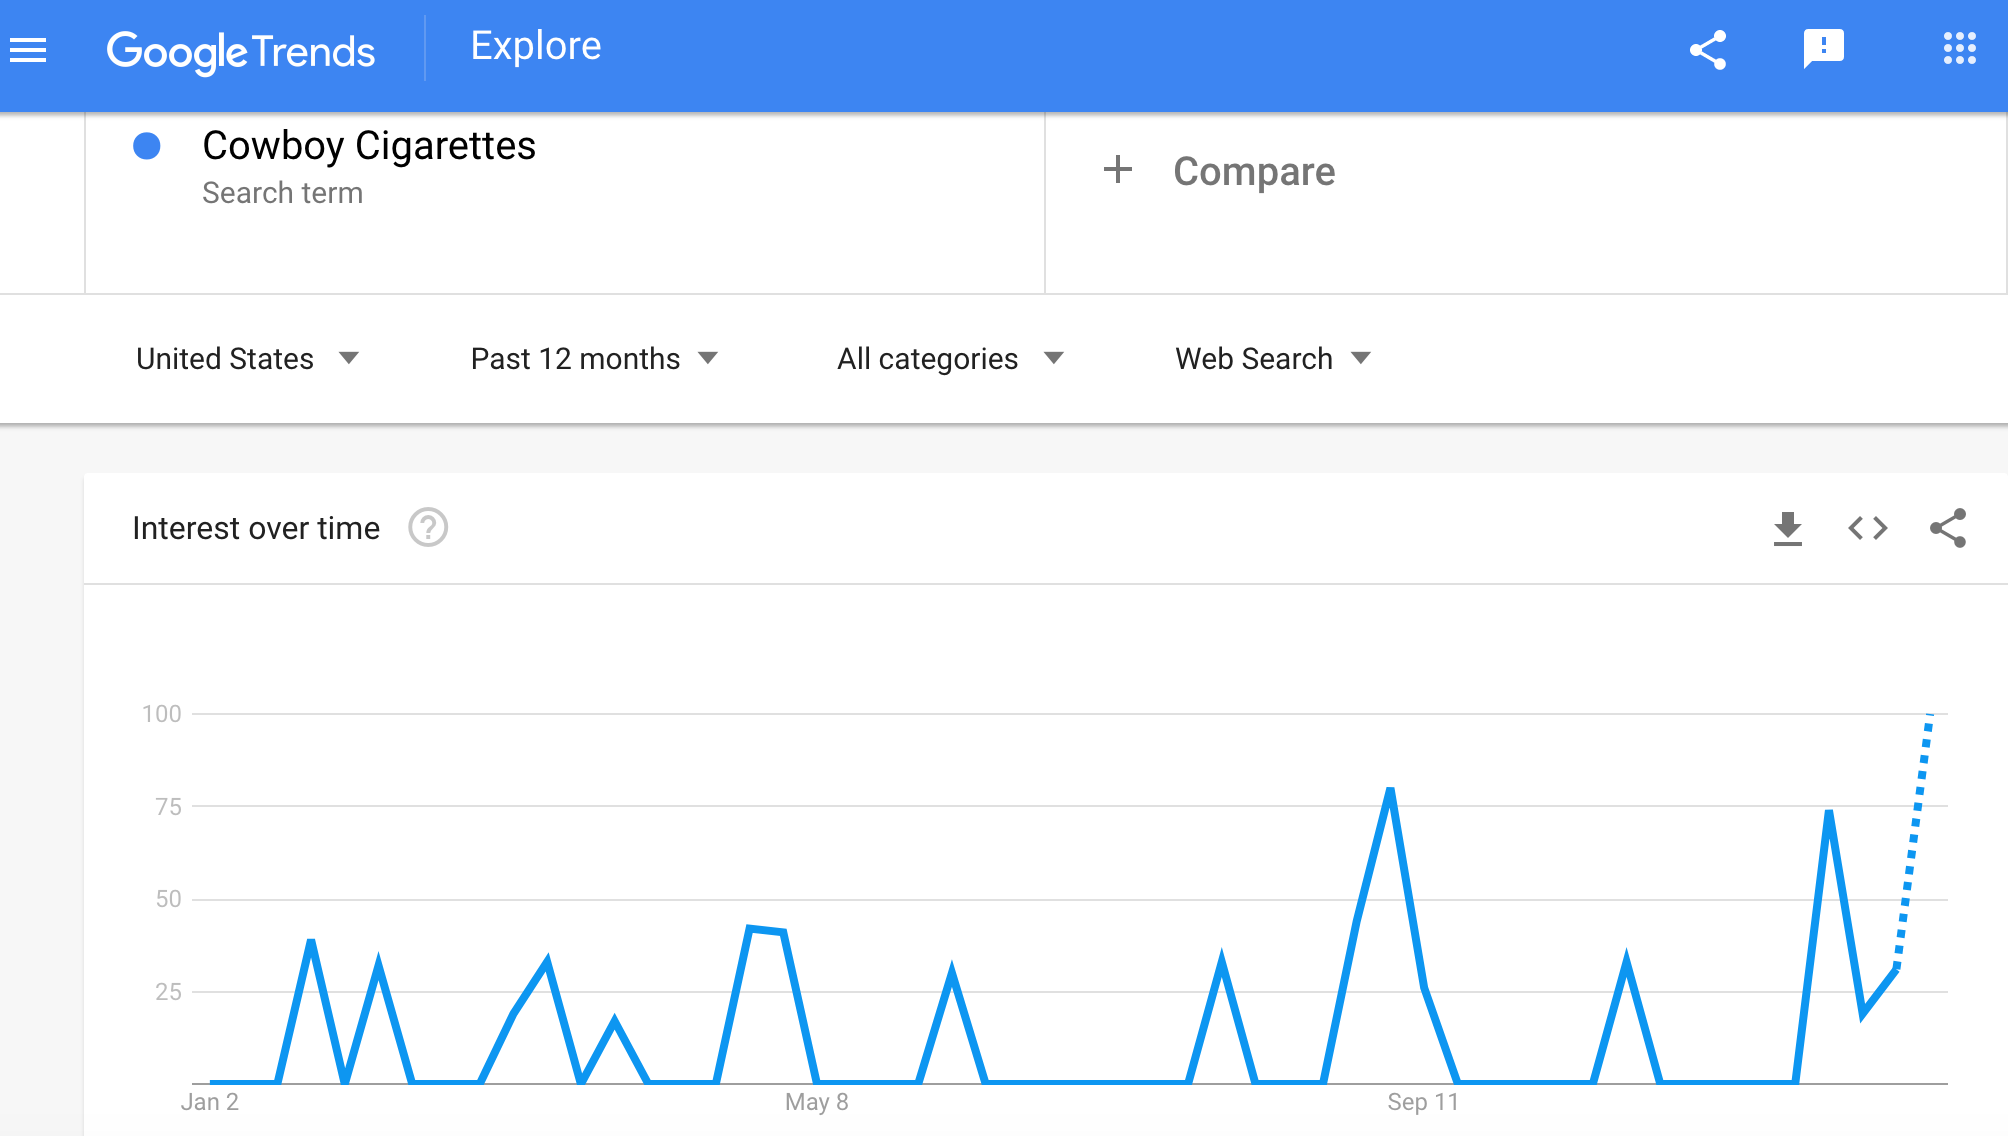

What we see above is a time history data.

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import itertools

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')
cigData.shape

(144, 3)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [5]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

In [6]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


Check whether there are any null values. 

In [7]:
#Counts of null values 
def count_null_values(data):
    na_df=pd.DataFrame(data.isnull().sum().sort_values(ascending=False)).reset_index()
    na_df.columns = ['VarName', 'NullCount']
    na_df = na_df[(na_df['NullCount']>0)]
    return na_df

count_null_values(cigData)

,VarName,NullCount


## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We do not need the unnecessary column `Unnamed: 0`. Delete it here.

Note: We could have also read the CSV file as `cigData = pd.read_csv('CowboyCigsData.csv', index_col = 'Unnamed: 0')` at the beginning to avoid the following step.

In [8]:
cigData = cigData.drop('Unnamed: 0', axis=1)
cigData.shape

(144, 2)

In [9]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [10]:
cigData.rename(columns= {'Time': 'Month'}, inplace=True)

Call `head()` to check this has worked. 

In [11]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


Or, a `sample()`.

In [12]:
cigData.sample(10)

,Month,#CigSales
87,1956-04,1000313
120,1959-01,1000360
99,1957-04,1000348
18,1950-07,1000170
141,1960-10,1000461
82,1955-11,1000237
62,1954-03,1000235
27,1951-04,1000163
118,1958-11,1000310
52,1953-05,1000229


### 2c. Type conversions 

Now, doing time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [13]:
cigData.Month = pd.to_datetime(cigData.Month)
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      144 non-null    datetime64[ns]
 1   #CigSales  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [14]:
cigData.set_index('Month', inplace=True)
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [15]:
cigData.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Since `freq=None`, we need to [change](https://stackoverflow.com/questions/46217529/pandas-datetimeindex-frequency-is-none-and-cant-be-set#:~:text=I%20have%20simply-,re%2Dbuild%20the%20index,-based%20on%20the) it to avoid an warning message later when we will do model `fit()` on ARIMA class (re: [statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html)). We will come back to this point later. For now, set `freq="MS"` as below.

In [16]:
cigData.index = pd.date_range(start = cigData.index[0],
                              end = cigData.index[-1], freq="MS")
cigData.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed `#CigSales` column. 

In [17]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [18]:
type(y)

pandas.core.series.Series

In [19]:
y

1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
               ...   
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432
Freq: MS, Name: #CigSales, Length: 144, dtype: int64

In [20]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [21]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

Before plotting `y`, we will substract a value of 1 million from all the values of `y` and work with a new set of values as defined by `y_new` below. This is fine since we are subsracting a constant value from all the `y` values. This will change the mean of the stochastic process, and we can always get the mean back by adding `1e6` to `y_new`.

In [22]:
y_new = y - 1e6

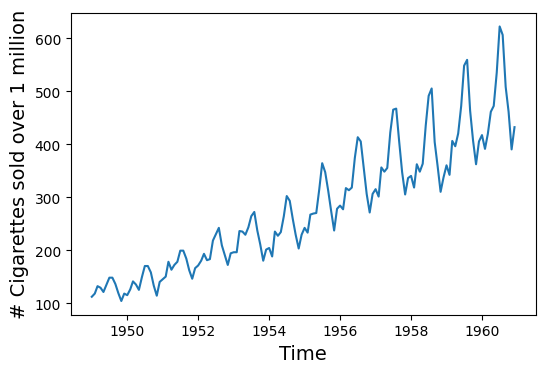

In [23]:
plt.figure(dpi = 100)

plt.plot(y_new)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('# Cigarettes sold over 1 million', fontsize = 14)
plt.show();

## 3. Modelling 
### 3a. Decomposition

The plot above sheds light on the following.

There is a general upward trend in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. When are these seasonal fluctuations happening? Let us hypothesize on their cause.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. Refer to [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) for further details.

-------------------------------

Afte referring to the article above, we can conclude that the Cowboy Cigarettes data is a multiplicative model. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

We can use the `decompose()` function (re: [statsmodels.tsa.seasonal.seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)) to quantify the component parts described above in our data.

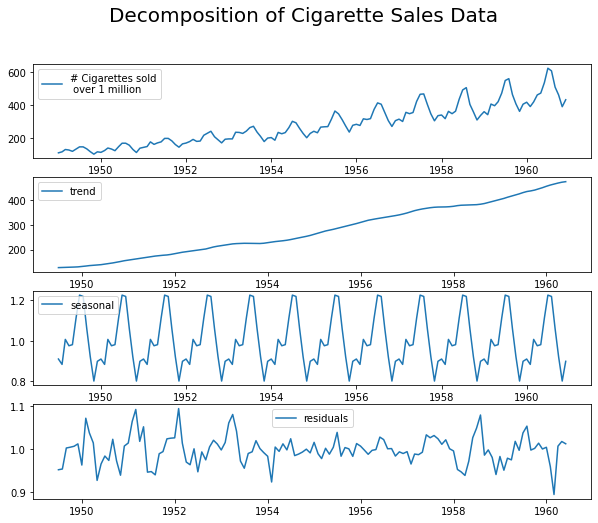

In [24]:
returns = seasonal_decompose(y_new, model='multiplicative')

trend = returns.trend
seasonal = returns.seasonal
resid = returns.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(10,8))

plt.subplot(411)
plt.plot(y_new, label = '# Cigarettes sold\n over 1 million')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label = 'trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(resid, label = 'residuals')
plt.legend(loc='best')

plt.suptitle("Decomposition of Cigarette Sales Data", fontsize = 20)

plt.show();

### 3b. Testing for stationarity with KPSS
When doing time series analysis, it is imperative to check for stationarity. Imprecisely, a time series dataset is stationary if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance. But, it can also have other notion of stationarity, such as, weak sense stationarity, strong sense stationarity.

There are many ways to test for stationarity, but one of the most common ways is the KPSS test (re: [statsmodels.tsa.stattools.kpss](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html)). The **Null hypothesis** of this test is that the time series data in question is stationary; hence, if the ***p*-value is less than the significance level** (typically 0.05, but we decide) then we reject the Null hypothesis and infer that the time series data that we collected **supports the alternative hypothesis** which states that the time series has a unit root (re: [KPSS test](https://en.wikipedia.org/wiki/KPSS_test)). A linear stochastic process has a unit root if 1 is a root of the process's characteristic equation. Such a process is non-stationary but does not always have a trend.

You can watch this [video](https://www.youtube.com/watch?v=ubzH1BJuUro) for some details of KPSS test.

In [25]:
result = kpss(y_new)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [26]:
result

(1.6513122354165206,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

We see that `kpss_stat` obtained above is `1.6513` which is more than all the critical values at 10%, 5%, 2.5% and 1% (based on [Kwiatkowski et al. (1992) paper](https://www.academia.edu/10990958/Testing_the_null_hypothesis_of_stationarity_against_the_alternative_of_a_unit_root)'s look-up table). This is the reason why we have the warning message above stating that `The test statistic is outside of the range of p-values available in the look-up table.` The actual *p*-value is much smaller than the returned *p*-value of 0.01. Therefore, we reject the Null hypothesis and deduce the non-stationarity of our time-series data.

But our data need to be stationary! So we need to do some transformation.

### 3c. Making the data stationary 
Let's recall what it looks like. 

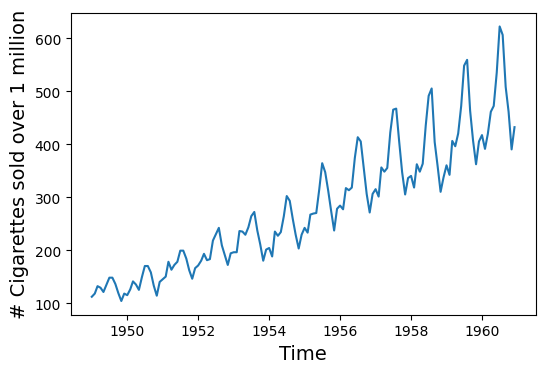

In [27]:
plt.figure(dpi = 100)

plt.plot(y_new)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('# Cigarettes sold over 1 million', fontsize = 14)
plt.show();

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [28]:
log_y = np.log(y_new)


When you plot this, you can see how the variance in our data now remains constant over time.

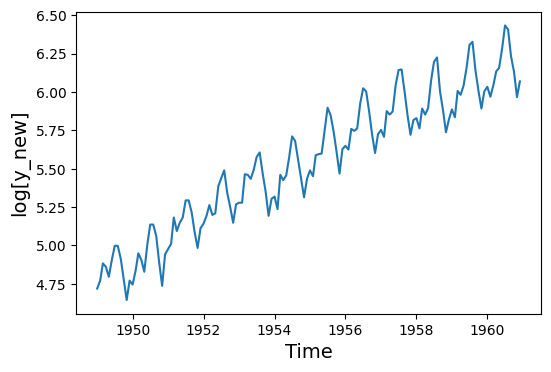

In [29]:
plt.figure(dpi = 100)

plt.plot(log_y)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('log[y_new]', fontsize = 14)
plt.show();

_________
**Digress**:

Let's also plot the log transformation of the original data `y`.

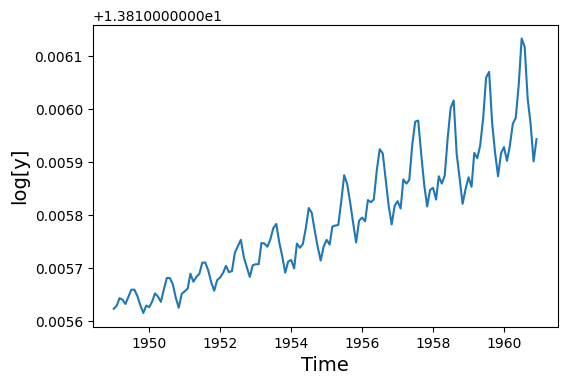

In [30]:
plt.figure(dpi = 100)

plt.plot(np.log(y))
plt.xlabel('Time', fontsize = 14)
plt.ylabel('log[y]', fontsize = 14)
plt.show();

The variance of the original data `y` does not seem to be constant over time in the above plot. But, if you carefully note the values of *y*-coordinates, then you will realize that the relative difference in the *y*-coordinates are practically insignificant as shown below.

In [31]:
min(np.log(y)), max(np.log(y))

(13.81561455255665, 13.816132364602451)

Thus, the characteristics of `y` and `y_new` are essentially same.
_______

Great! We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [32]:
log_diff = log_y.diff().dropna()

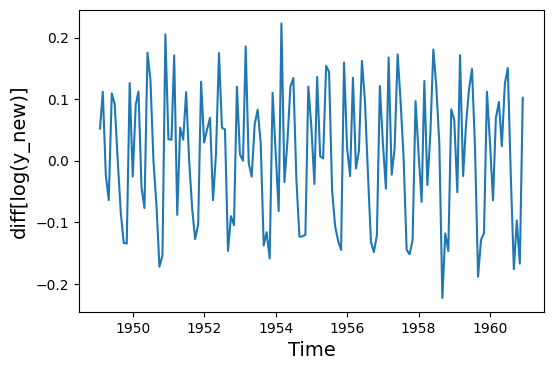

In [33]:
plt.figure(dpi = 100)

plt.plot(log_diff)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('diff[log(y_new)]', fontsize = 14)
plt.show();

In [34]:
result = kpss(log_diff)
result

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.03830446954674065,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The `kpss_stat` of `log_diff` data now is `0.0383` which is much smaller than all the critical values at 10%, 5%, 2.5% and 1%. As stated earlier, this is again the reason why we see the above warning message. The actual *p*-value in this case is much greater than the returned *p*-value of 0.1. Therefore, we **fail to reject** (note that *fail to reject* is **not** same as *accept*) the Null hypothesis that new times series data `log_diff` is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes that there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA` (re: [statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html)), both of which we have already imported.

An ARIMA model can be created using the `statsmodels` library as follows:

+ Define the model by calling `ARIMA()` and passing in the `p`, `d`, and `q` parameters.

+ The model is prepared on the training data by calling the `fit()` function.

+ Predictions or forecasting can be made by calling the `predict()` or `forecast()` functions and specifying the index of the time or times to be predicted. 

#### 3di. Rolling Forecast ARIMA Model

The `forecast()` and  `predict()` functions are used on the [ARIMAResults](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html) object to make predictions. As mentioned above, it accepts the index of the time steps as arguments to make predictions. These indexes are relative to the start of the training dataset used to make predictions.

Let us write a function to carry out these operations for a single ARIMA model and also to estimate its MSE.

In [35]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model

def evaluate_arima_model(train, test, arima_order):
    
    past=[x for x in train]
    
    # Instantiate prediction values
    predictions = list()
    
    # Walk-forward predictions or Rolling forecast ARIMA Model
    # timestep-wise comparison between test data and one-step prediction
    # ARIMA model.
    for i in range(len(test)): 
        
        # Fit model
        model = ARIMA(past, order = arima_order)
        # model_fit = model.fit(disp=0) # disp = 0 controls the frequency of the output 
                                        # during the iterations.
        model_fit = model.fit()
        
        # Predict
        future = model_fit.forecast()[0]
        predictions.append(future)
        
        # Update past by rolling forward and including latest observation that
        # has already been used
        past.append(test[i])
    
    # Evaluate forecasts by calculating the MSE of the entire ARIMA model
    error = mean_squared_error(test, predictions)
    
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [36]:
# Make a function called evaluate_models to evaluate different ARIMA models 
# with several different p, d, and q values.

# Ref: https://medium.com/swlh/a-brief-introduction-to-arima-and-sarima-modeling-in-python-87a58d375def

def model_eval(train, test, pdq):
    
    combs = {} # stores mse and order pairs
    MSEs = [] # stores mse
    
    # Grid Search
    for arima_order in pdq:
        
        # Make a variable called mse for the Mean squared error
        mse = evaluate_arima_model(train, test, arima_order)
        
        combs.update({mse: arima_order}) # store combinations
        MSEs.append(mse)
        
        print(f"ARIMA{arima_order}: MSE = {mse}")
       
    # Best model
    best_mse = min(MSEs)
    best_order = combs[best_mse]
    
    print(f"\nBest ARIMA{best_order}: MSE = {best_mse}")    
    
    return best_mse, best_order

Before we start calling all the functions, let's start off with something simple. We will fit an ARIMA model to the entire `log_y` data and review the residual errors.

**Note**: The 0th value of prrediction is in general considered as "missing value" ([link](https://stackoverflow.com/questions/35593759/python-arima-model-predicted-values-are-shifted#:~:text=the%200th%20value%20should%20be)). So, we should remove the 0th value from the predictions and the original data when plotting or calculating any error or statistics. Or, we can add an artificial data point (with a reasonable value, or, say 0 value) at the immediately previous time step before the start time, and later ignore it after prediction is done.

In [37]:
def fit_inspect_arima_model(data, arima_order):
    
    # Fit model
    model = ARIMA(data, order=arima_order)
    model_fit = model.fit()

    # Summary of fit model
    print(model_fit.summary())

    # Line plot of residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals = residuals[1:] # Dropping the 0th value
    residuals.plot()
    plt.title("Line plot of residuals")
    plt.show()

    # Density plot of residuals
    residuals.plot(kind='kde')
    plt.title("Density plot of residuals based on kernel density estimation (kde)")
    plt.show()

    # Summary stats of residuals
    print(residuals.describe())
    
    return model_fit

In [38]:
log_y

1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Freq: MS, Name: #CigSales, Length: 144, dtype: float64

We can now either add an artificial data point for the month of 1948-12-01 (just before the start time) and ignore it later for plotting purspose and calculating error purpose, or, simpply move forward without this artifical point. If we do not this arrttificial point, then we would remove the 0th value from both the predictions and the original data for the plotting and calculating error purpose. 

Let's not add any artificial point.

In [39]:
# initial_index = pd.to_datetime("1948-12-01", format="%Y-%m-%d")
# initial_value = log_y[0] - ((log_y[1]-log_y[0])/(log_y.index[1].month - log_y.index[0].month))
# initial_row = pd.Series(initial_value, index=[initial_index])
# log_y = pd.concat([initial_row, log_y])
# log_y

In [40]:
log_y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

As mentioned earlier, if `freq=None`, then We would have to convert the index from `DatetimeIndex` to `PeriodIndex` by passing a frequency through `to_period` to avoid the following warning (see [stackoverflow response](https://stackoverflow.com/questions/58510659/error-valuewarning-a-date-index-has-been-provided-but-it-has-no-associated-fr#:~:text=to%20DatetimeIndex%20and-,pass%20a%20frequency,-by%20to_period%3A)) or fixing the index using `date_range(freq = 'MS')` as we already did. This is what we briefly mentioned earlier in Section 2c when we mentioned that we would come back to the point that index of `y` has `freq=None`. 
```
ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
```

                               SARIMAX Results                                
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.313
Date:                Sat, 31 Dec 2022   AIC                           -242.626
Time:                        19:43:48   BIC                           -233.738
Sample:                    01-01-1949   HQIC                          -239.014
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5774      0.164     -3.517      0.000      -0.899      -0.256
ma.L1          0.8478      0.098      8.687      0.000       0.657       1.039
sigma2         0.0103      0.002      5.992      0.0

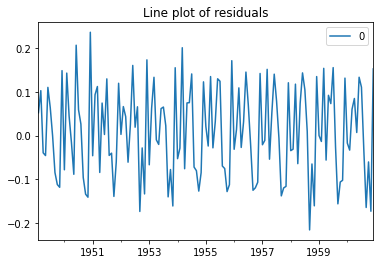

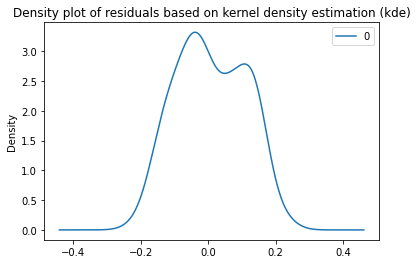

                0
count  143.000000
mean     0.008357
std      0.101397
min     -0.214937
25%     -0.070539
50%     -0.000386
75%      0.097737
max      0.235476


In [41]:
# Fit an ARIMA model to the entire log_y data and review the results
model_fit = fit_inspect_arima_model(log_y, arima_order = (1,1,1))

+ First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

+ Second, we get a density plot of the residual error values, suggesting the errors are centered around 0 and the density is symmetric around 0, but the density is not Gaussian. This implies that this model is not the best one.

+ Third, the statistics of the residual errors is displayed. The results show that indeed it is almost a zero mean residuals and symmetric around 0 since min and max are almost symmetrically located about 0.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics (we already did a bit of it above) to ensure that none of the assumptions made by the model have been violated. The `plot_diagnostics` object further allows us to quickly generate a fairly detailed model diagnostics and investigate for any unusual behavior.

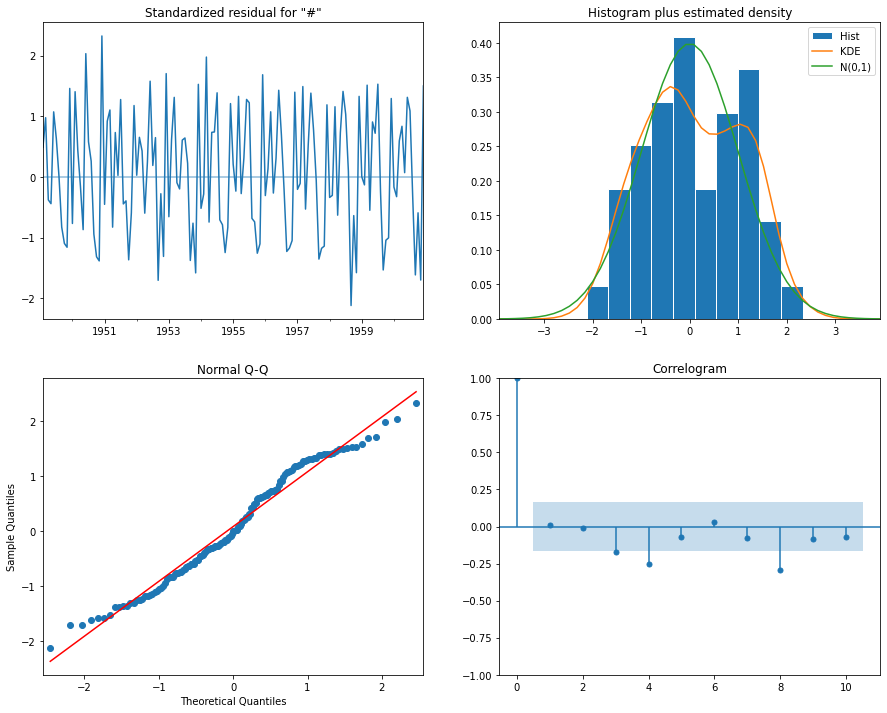

In [42]:
# Generate model diagnostics and investigate for any unusual behavior.
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggest that the model residuals are **approximately** (there are some issues) normally distributed based on the following:

+ In the top right plot, we see that the red KDE line does **not** follow closely the `N(0,1)` line (where `N(0,1)` is the standard notation for a normal distribution with mean `0` and standard deviation of `1`). This is possibly an issue for the ARIMA model of order `(1,1,1)` that we considered above.

+ The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) does not follow quite well the linear trend of the samples taken from a standard normal distribution with `N(0, 1)`. Again, this is a strong indication that the the ARIMA model is not the best.

+ The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have a low correlation with lagged versions of themselves.

These observations lead us to conclude that our model is possibly not a satisfactory fit that could help us understand the time series data and forecast future values.

Since we do not have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. To achieve this, we can do a grid search as follows.

In [43]:
# Ref: https://medium.com/swlh/a-brief-introduction-to-arima-and-sarima-modeling-in-python-87a58d375def

# Grid Search
# p, d, and q can be either 0, 1, or 2
p = d = q = range(0,3)

# Gets all possible combinations of p, d, and q
pdq = list(itertools.product(p,d,q))

In [44]:
# Finally, we can find the optimum ARIMA model for our data.
# This can take a while...

# warnings.filterwarnings('ignore')

train_size = 0.8

# Split into train and test sets
# Needs to be an integer because it is later used as an index.
# Use int()
split = int(len(log_y) * train_size) 
    
# Make train and test variables, with 'train, test'
train, test = log_y[0:split], log_y[split:len(log_y)]
    
print(f"len(train): {len(train)}")
print(f"len(test): {len(test)}")

best_mse, best_order  = model_eval(train, test, pdq)

len(train): 115
len(test): 29


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 0): MSE = 0.38477611293489583


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1): MSE = 0.10829708553861102


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2): MSE = 0.04273568746592185


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0): MSE = 0.01330392652855115
ARIMA(0, 1, 1): MSE = 0.0122330716507363
ARIMA(0, 1, 2): MSE = 0.012940027146748152


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 0): MSE = 0.019134605665814045
ARIMA(0, 2, 1): MSE = 0.013631934471574096


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2): MSE = 0.012481753762554297
ARIMA(1, 0, 0): MSE = 0.013315156007605907
ARIMA(1, 0, 1): MSE = 0.012247751788360302


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2): MSE = 0.012946590036246262
ARIMA(1, 1, 0): MSE = 0.012411157631684537
ARIMA(1, 1, 1): MSE = 0.01211898669980835
ARIMA(1, 1, 2): MSE = 0.01101167380365444
ARIMA(1, 2, 0): MSE = 0.018334279268727112


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1): MSE = 0.012666485078657443


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

ARIMA(1, 2, 2): MSE = 0.012364272021933024


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0): MSE = 0.012358174019585756


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1): MSE = 0.01215601000439637


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to conver

ARIMA(2, 0, 2): MSE = 0.012130876280660355
ARIMA(2, 1, 0): MSE = 0.012312181208084312
ARIMA(2, 1, 1): MSE = 0.009996424091988464
ARIMA(2, 1, 2): MSE = 0.011151526693751598
ARIMA(2, 2, 0): MSE = 0.018895521133764734


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

ARIMA(2, 2, 1): MSE = 0.012593782138210184


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

ARIMA(2, 2, 2): MSE = 0.012424889722841219

Best ARIMA(2, 1, 1): MSE = 0.009996424091988464


Ok, optimizations for some of the `pdq`-order combinations did not converge. Regardless, we obtained a best model for `(2,1,1)` for which optimization converged without any error message. We will move ahead with this best combination and build our ARIMA model.

In [45]:
# Model Creation and Forecasting
model = ARIMA(log_y, order = best_order)
model_fit = model.fit()

We can take a look at a summary of the model this library has built around our data.

In [46]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 129.732
Date:                Sat, 31 Dec 2022   AIC                           -251.464
Time:                        19:45:50   BIC                           -239.612
Sample:                    01-01-1949   HQIC                          -246.648
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9792      0.100      9.839      0.000       0.784       1.174
ar.L2         -0.3740      0.118     -3.177      0.001      -0.605      -0.143
ma.L1         -0.8303      0.102     -8.118      0.000      -1.031      -0.630
sigma2         0.0095      0.002      6.134      0.000       0.006       0.013
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 8.63
Prob(Q):                              0.31   Prob(JB):                         0.01
Heteroskedasticity (H):               1.14   Skew:                             0.22
Prob(H) (two-sided):                  0.66   Kurtosis:                         1.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

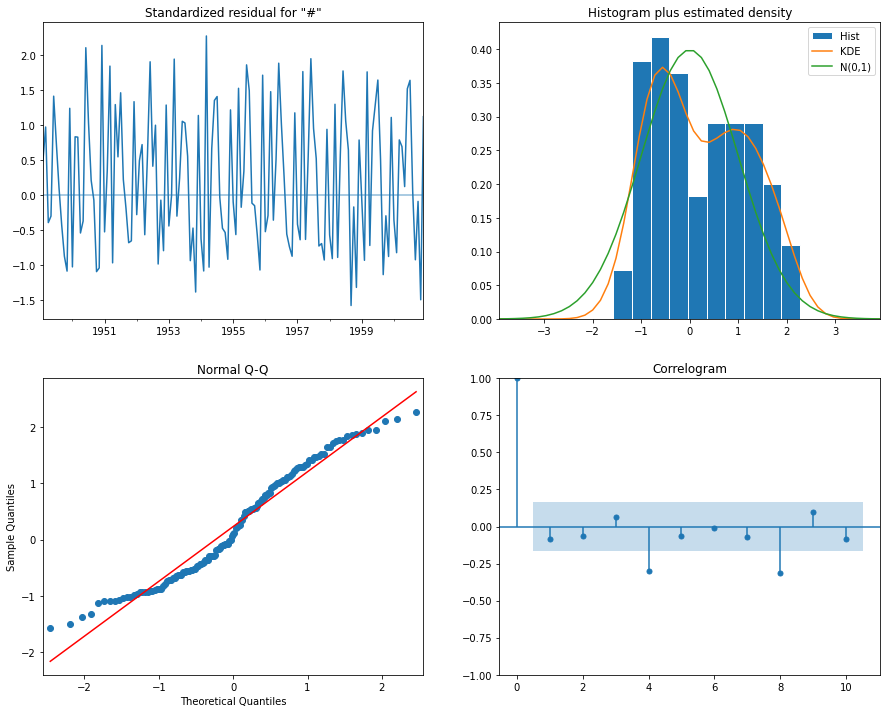

In [47]:
# Generate model diagnostics and investigate for any unusual behavior.
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

The observations that we made earlier for the ARIMA model of order `(1,1,1)` remain same even for our best ARIMA model obtained above for order `(2,1,1)`.  Since our grid search only considered a restricted set of parameter combinations, we may find better models if we widen the grid search.

For now, we will, however, move ahead with the best model that we obtained above based on our search so far.

#### 3diii. Make predictions from the best model

In [48]:
#forecast = model_fit.forecast(steps = len(test))[0]
log_y_predict = model_fit.predict()

In [49]:
log_y_predict # Note that 0th value is essentially a "missing value" in prediction

1949-01-01    0.000000
1949-02-01    4.718499
1949-03-01    4.781493
1949-04-01    4.899545
1949-05-01    4.825728
                ...   
1960-08-01    6.401154
1960-09-01    6.320259
1960-10-01    6.142036
1960-11-01    6.111471
1960-12-01    5.959342
Freq: MS, Name: predicted_mean, Length: 144, dtype: float64

In [50]:
log_y

1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Freq: MS, Name: #CigSales, Length: 144, dtype: float64

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. Before plotting, we need to convert `PeriodIndex` back to `DatetimeIndex` to avoid the following error message (see [stackoevrflow response](https://stackoverflow.com/questions/29394730/converting-periodindex-to-datetimeindex#:~:text=22-,You%20can%20use,-the%20to_timestamp%20method)):

```
TypeError: float() argument must be a string or a real number, not 'Period'
```

In [51]:
log_y_predict.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [52]:
type(log_y_predict.index)

pandas.core.indexes.datetimes.DatetimeIndex

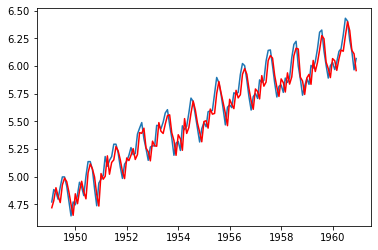

In [53]:
plt.figure()

# Dropping the 0th value and then plotting
plt.plot(log_y[1:])
plt.plot(log_y_predict[1:], color='red')

plt.show();

The model predictions align with the true values very well, showing an overall increasing trend.

In [54]:
train

1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1958-03-01    5.891644
1958-04-01    5.852202
1958-05-01    5.894403
1958-06-01    6.075346
1958-07-01    6.196444
Freq: MS, Name: #CigSales, Length: 115, dtype: float64

In [55]:
test

1958-08-01    6.224558
1958-09-01    6.001415
1958-10-01    5.883322
1958-11-01    5.736572
1958-12-01    5.820083
1959-01-01    5.886104
1959-02-01    5.834811
1959-03-01    6.006353
1959-04-01    5.981414
1959-05-01    6.040255
1959-06-01    6.156979
1959-07-01    6.306275
1959-08-01    6.326149
1959-09-01    6.137727
1959-10-01    6.008813
1959-11-01    5.891644
1959-12-01    6.003887
1960-01-01    6.033086
1960-02-01    5.968708
1960-03-01    6.037871
1960-04-01    6.133398
1960-05-01    6.156979
1960-06-01    6.282267
1960-07-01    6.432940
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Freq: MS, Name: #CigSales, dtype: float64

In [56]:
pred = model_fit.get_prediction(start=pd.to_datetime('1958-08-01'), dynamic=False)
pred_ci = pred.conf_int()

The `dynamic=False` argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

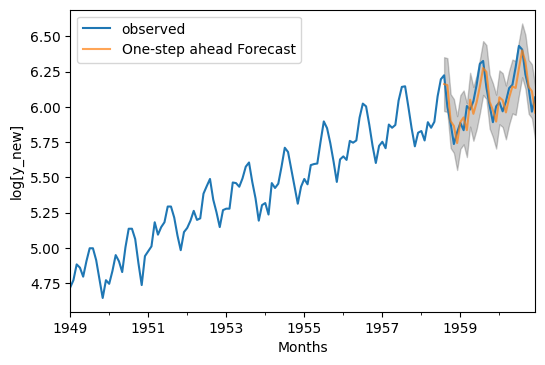

In [57]:
plt.figure(dpi = 100)

ax = log_y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Months')
ax.set_ylabel('log[y_new]')
plt.legend()

plt.show()

Again,  all predicted values (orange line) match pretty closely to the ground truth (blue line) and are well within the confidence intervals of our forecast which is also not very wide. This gives us confidence to use this model for forcasting beyond the range of dates available out in the future.

### 3f. Application: Forecasting

As indicated earlier, even though the best mdoel violates the assumptions made by the ARIMA model (residuals not following normal distribution), our model fits pretty closely to our existing data as we seen above. To revise our ARIMA model, we can try fitting another ARIMA model by widening our grid search or using an ARIMA model that [allows to fit non-normal distributions](https://stats.stackexchange.com/questions/96598/what-if-the-residual-series-from-arima-not-looks-normal#:~:text=which%20do%20not%20assume%20normality), say, *t*-distribution or Beta distribution to  the residuals. We will not go to that route since we see above that our model fits the training data pretty well. Let's use our best model to forecast what's likely to occur in future.

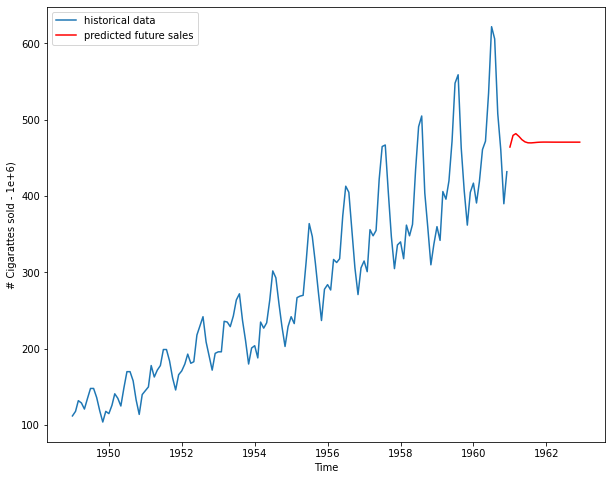

In [58]:
# Declare a variable called forecast_period with the amount of months to forecast,
# and create a range of future dates that is the length of the periods you've 
# chosen to forecast

forecast_period = 24
# forecast_period = len(test) + int(len(test) * 0.25) 

future_dates = pd.date_range(start = pd.to_datetime('1961-01-01'), periods = forecast_period, freq = 'MS')
# future_dates = pd.date_range(start = y.index[-1], periods = forecast_period, freq = 'MS')


# Convert that range into a dataframe that includes your predictions

sales_predictions = pd.DataFrame(data = future_dates, columns = ['Month'])
sales_predictions['log(sales)'] = model_fit.forecast(steps = forecast_period).values
sales_predictions['sales_predict'] = np.exp(sales_predictions['log(sales)']).values

sales_predictions.set_index('Month', inplace=True)

# Plot your future predictions
plt.figure(figsize=(10,8))

plt.plot(y_new, label = 'historical data')
plt.plot(sales_predictions['sales_predict'], color='red', label = 'predicted future sales')
plt.xlabel('Time')
plt.ylabel('# Cigarattes sold - 1e+6)')
plt.legend()
plt.show();

In [59]:
# # Declare a variable called forecast_period with the amount of months to forecast, and
# # create a range of future dates that is the length of the periods you've chosen to forecast
# forecast_period = 24
# date_range = pd.date_range(log_y.index[-1], periods = forecast_period, 
#               freq='MS').strftime("%Y-%m-%d").tolist()

# # Convert that range into a dataframe that includes your predictions
# # First, call DataFrame on pd
# future_months = pd.DataFrame(date_range, columns = ['Month'])
# # Let's now convert the 'Month' column to a datetime object with to_datetime 
# future_months['Month'] = pd.to_datetime(future_months['Month'])
# future_months.set_index('Month', inplace = True)

# forecast = model_fit.forecast(steps = forecast_period)
# future_months['Prediction'] = forecast

# # Plot your future predictions
# # Call figure() on plt
# plt.figure(figsize=(15,10))
# plt.plot(log_y)
# plt.plot(log_y['Nov 1960'].append(future_months['Prediction']))
# plt.show()

In [60]:
forecast_period

24

In [61]:
# Get forecast 24 steps ahead in future
pred_uc = model_fit.get_forecast(steps=forecast_period)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

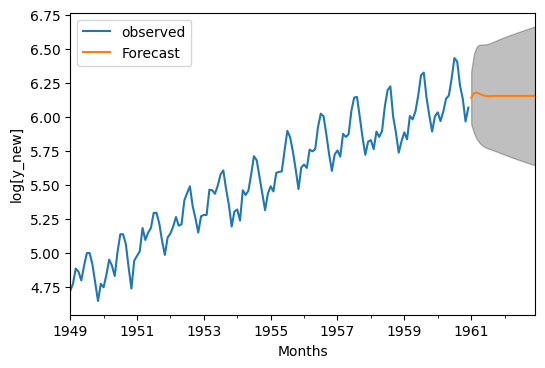

In [62]:
plt.figure(dpi = 100)

ax = log_y.plot(label='observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Months')
ax.set_ylabel('log[y_new]')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is not expected to continue increasing at a steady pace. This raises concern about reliability of our model. Recall that the best mdoel, that we used above, violates the assumptions made by the ARIMA model -- residuals not following normal distribution, etc.

However, as we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by the model, which grow larger as we move further out into the future.

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate **in the range of dates of the observed data**. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

If we are interested in discovering the causes of the cigarette sales trajectory, then we could execute a regression analysis in addition to the time series one.

But, note that, the **out-of-sample forecast does not seem to increase** with time, while the confidence intervals generated by the model are significantly wide as we step out of the range of dates of the observed data. Therefore, the model certainly needs to be improved further to forecast beyond the available range of dates of the observed data.